# chromatic_fitting

Add-on to the [chromatic](https://github.com/zkbt/chromatic) package to perform a simultaneous multi-wavelength transit fit

In [1]:
from src.inject_spectrum import *
from src.plot.interactive_plots import *
from src.weighted_average_lc import *
from src.recover_transit import *
from src.utils import *
from chromatic_fitting import *
from chromatic import Rainbow

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.0
Running on PyMC v3.11.2
Running on ArviZ v0.12.0
Running on Exoplanet v0.5.2


## Import Spectrum Model and Inject into Rainbow

In [2]:
# x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
# planet = x['WASP39b_NIRSpec']
# planet_params = x['WASP39b_parameters']
# planet_params

In [3]:
star_params = {"M_H": -0.03,
                   "Teff": 5326.6, 
                   "logg": 4.38933,
                   "r_s" : 0.895,
                   "m_s" : 0.93,
                  }

injplanet_params = {
                "t0": 0,
                "per": 4.055259, # orbital period (days), Faedi et al. 2011
                "a": 11.37, # semi-major axis (stellar radii)
                "inc": 87.83, # inclination (degrees), Faedi et al. 2011
                "ecc": 0,
                "w": 0
            }

In [4]:
def load_model_inject_transit():
    from astropy.io import ascii
    from astropy.table import Table
    
    bintime=5
    binwave=0.2
    
    # load Patricio's spectrum model:
    model_staticld, planet_params, wavelength,transmission = import_patricio_model()
    # add LD coeffs:
    model_ld = add_ld_coeffs(model_staticld, planet_params, wavelength,transmission,mode="NIRCam_F322W2",star_params=star_params,plot=True)

    # calculate the semi-major axis in stellar radii from the value in AU
    # a_AU = 0.0486 # Faedi et al. 2011
    # solar_radius_AU = 0.00465047
    # stellar_radius = 0.895
    # a_stellar_radii = a_AU/(solar_radius_AU * stellar_radius)

    # return synthetic rainbow + rainbow with injected transit:
    r,i = inject_spectrum(model_ld, snr=1000, dt=bintime, res=50, planet_params=injplanet_params)

    # bin in time and wavelength (to speed up fitting)
    b_withouttransit = r.bin(
            dw=binwave * u.micron, dt=bintime * u.minute
    )
    b_withtransit = i.bin(
            dw=binwave * u.micron, dt=bintime * u.minute
    )
    
    # save Rainbow to speed up notebook!
    b_withtransit.save(fname)
    ascii.write(model_ld.table,fname_model, overwrite=True)  

In [5]:
fname = "test/b_withtransit.rainbow.npy"
fname_model = 'test/patricio_model_ld.dat'

In [10]:
# to import patricio's model, add the LD coeffs and inject transit into Rainbow: 
# load_model_inject_transit()

# to load the saved model and Rainbow
b_withtransit = Rainbow(fname)
# synthetic_planet(table=table, label='injected model')
model_ld = synthetic_planet(table=Table.read(fname_model, format='ascii'), label='injected model')

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans


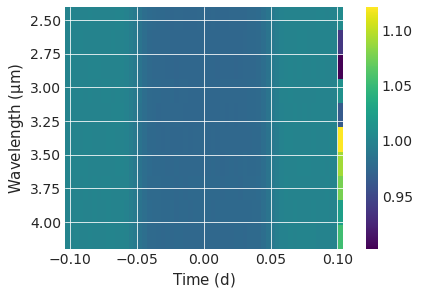

In [11]:
b_withtransit.imshow();

In [12]:
b_withtransit.imshow_interact(custom_ylims=[0.96,1.02])

alt.HConcatChart(...)

In [13]:
b_withtransit.imshow_interact(quantity='uncertainty')

alt.HConcatChart(...)

## Setup Chromatic_Fitting model
Define the priors!

In [14]:
# set initial parameter estimates:
init_t0=0.0
init_period = 4.055259
period_error = 0.000009
init_b=0.44
init_r=0.14
init_mean = 0.0
init_u = [0.05,0.35]
r_s = star_params['r_s']#0.895
m_s = star_params['m_s']#0.93

# create chromatic model:
cm = chromatic_model()
print(cm)

# init priors (use same distribution format as pyMC3):
m_s_prior = cm.Normal('m_s', mu=r_s, sigma=0.05, observed=r_s)    # Mass of star (Solar mass, fixed)
r_s_prior = cm.Normal('r_s', mu=m_s, sigma=0.05, observed=m_s)    # Radius of star (Solar radius, fixed)
r_prior = cm.Uniform("r", lower=0.01, upper=0.3, testval=init_r)  # Radius ratio
mean_prior =  cm.Normal("mean", mu=init_mean, sigma=0.0025)       # Lightcurve mean
t0_prior = cm.Normal("t0", mu=init_t0, sigma=0.05)                # Transit epoch (days)
# logP_prior = cm.Normal("logP", mu=np.log(init_period), sigma= np.log(period_error)) - why does this not fit?
logP_prior = cm.Uniform("logP", testval=np.log(init_period), lower=np.log(init_period-(10*period_error)),upper=np.log(init_period+(10*period_error))) # Log(Period, days)

<chromatic_model 🌈>


### Initialise the Model (wavelength-indep parts)

In [15]:
# Initialise the (wavelength-independent) model:
cm.initialise_model(r_s_prior, m_s_prior, r_prior, logP_prior, t0_prior, mean_prior, init_b=init_b, init_u=init_u)

Initialising (static) model took --- 6.386608839035034 seconds ---


Let's look at the model so far:

In [12]:
print(cm.model)

logP_interval__ ~ TransformedDistribution
             t0 ~ Normal
     b_impact__ ~ TransformedDistribution
           logP ~ Uniform
         period ~ Deterministic
              b ~ ImpactParameter
              a ~ Deterministic
              i ~ Deterministic
          a/r_s ~ Deterministic
            r_s ~ Normal
            m_s ~ Normal


### Quick Check

How do the priors look compared to the wavelength-averaged data?

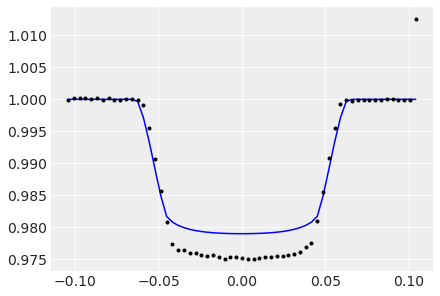

In [13]:
quicklook_priors(b_withtransit,cm)

### Optimise the Model

Run the model, choosing the optimisation we want:
- _weighted_average_
- _separate_wavelengths_
- _simultaneous_

If you want to rerun the model with a different optimisation you need to **.reinitialise()**! 

You can also **.reinitialise()** and apply the model to a different Rainbow object

MAD (entire LC) = 9390.285335826975 ppm
MAD (5-min binned) = 9600.622396672587 ppm
Weighted Average LC took --- 0.028973102569580078 seconds ---


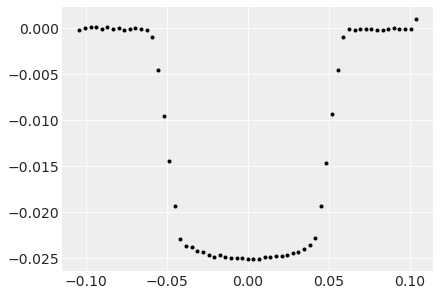

Initialising r/u/mean took --- 0.2170090675354004 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -4131.064066577231 -> 446.8251549536902


Optimising model took --- 5.873274803161621 seconds ---
Number of Wavelengths fit : 1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


list indices must be integers or slices, not str


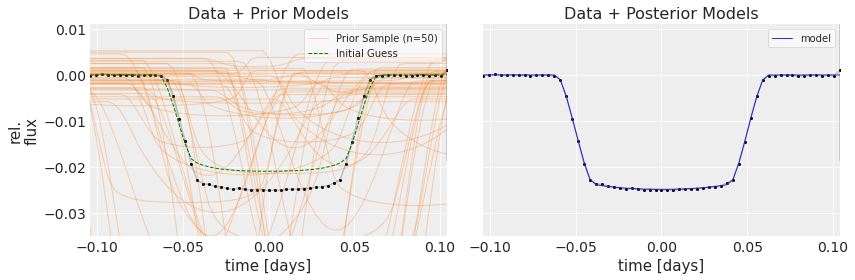

Plotting took --- 0.713475227355957 seconds ---


In [14]:
# cm.reinitialise()
cm.run(r=b_withtransit, optimisation="weighted_average", plot=True)

Let's look at the model again:

In [15]:
print(cm.model)

 logP_interval__ ~ TransformedDistribution
              t0 ~ Normal
      b_impact__ ~ TransformedDistribution
    r_interval__ ~ TransformedDistribution
            mean ~ Normal
u_quadlimbdark__ ~ TransformedDistribution
            logP ~ Uniform
          period ~ Deterministic
               b ~ ImpactParameter
               a ~ Deterministic
               i ~ Deterministic
           a/r_s ~ Deterministic
               r ~ Uniform
               u ~ QuadLimbDark
             r_p ~ Deterministic
    light_curves ~ Deterministic
             r_s ~ Normal
             m_s ~ Normal
             obs ~ Normal


You can change a prior and run again:

In [ ]:
cm.change_prior(cm.Uniform("logP", testval=np.log(init_period), lower=np.log(init_period-(10*period_error)), upper=np.log(init_period+(10*period_error))))
cm.run(r=b_withtransit, optimisation="weighted_average", plot=True)

Or the rainbow:

In [ ]:
# create a new Rainbow with lower SNR:
r2,i2 = inject_spectrum(model_ld, snr=100, dt=bintime, res=50, planet_params=injplanet_params)
b_withouttransit2 = r2.bin(
        dw=binwave * u.micron, dt=bintime * u.minute
)
# Reinitialise and rerun model on new Rainbow
cm.reinitialise()
cm.run(r=b_withtransit2, optimisation="weighted_average", plot=True)

### Sample the posterior

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 26.00040102005005 seconds ---
Number of Wavelengths fit : 1


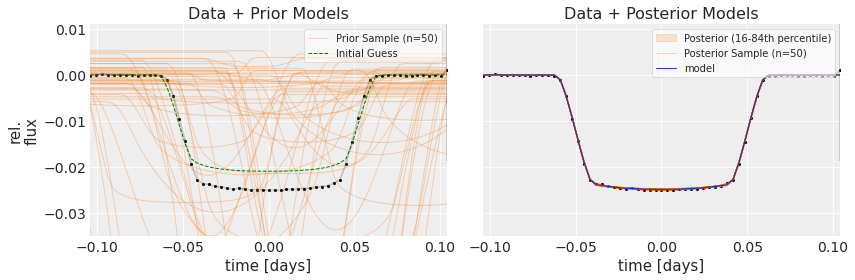

In [16]:
cm.sample_posterior(tune_steps=600,draws=1200,target_accept=0.9)

Check the MCMC chains:

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


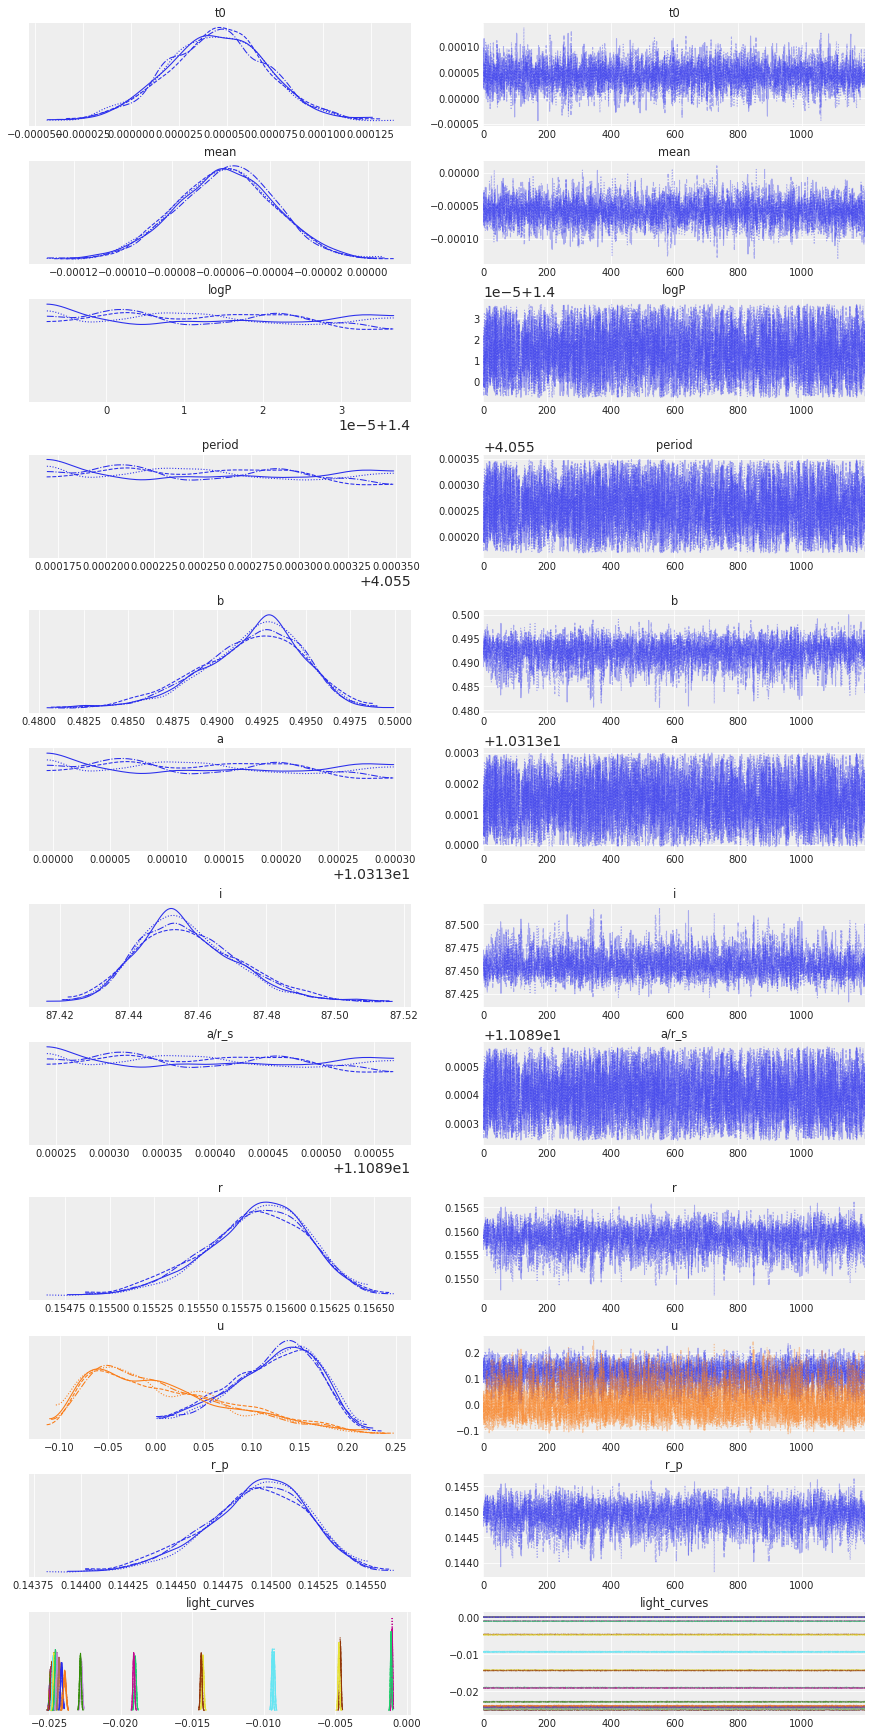

In [17]:
cm.plot_trace();

You can change the properties of the sampling:

In [ ]:
cm.sample_posterior(tune_steps=4000,draws=8000,target_accept=0.8)

Plot the posterior distributions in a corner plot and a summary table: 

In [ ]:
cm.cornerplot()
summary = cm.summarise()
summary

### Optimise using a Different Method (separate wavelength fitting)

Initialising (static) model took --- 0.2501699924468994 seconds ---
Wavelength:  2.4030137062072754
Initialising r/u/mean took --- 0.221282958984375 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1001.285923897921 -> 383.7579716744209


Optimising model took --- 5.8240602016448975 seconds ---
Number of Wavelengths fit : 1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


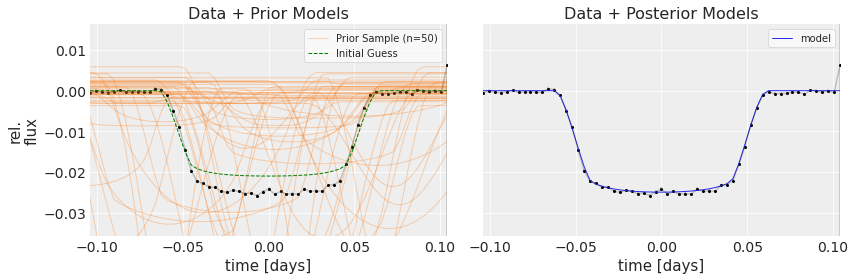

Plotting took --- 1.2659101486206055 seconds ---
Wavelength:  2.6030137062072756
Initialising (static) model took --- 0.24635887145996094 seconds ---
Initialising r/u/mean took --- 0.14003205299377441 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -2209.1935795334725 -> 409.4096980538482


Optimising model took --- 3.246377944946289 seconds ---
Number of Wavelengths fit : 1


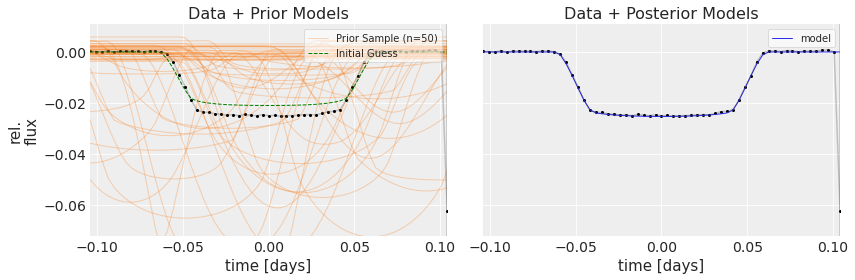

Plotting took --- 0.6568219661712646 seconds ---
Wavelength:  2.8030137062072757
Initialising (static) model took --- 0.22903895378112793 seconds ---
Initialising r/u/mean took --- 0.1358330249786377 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -3182.4279585498603 -> 406.6119149757202


Optimising model took --- 3.3086090087890625 seconds ---
Number of Wavelengths fit : 1


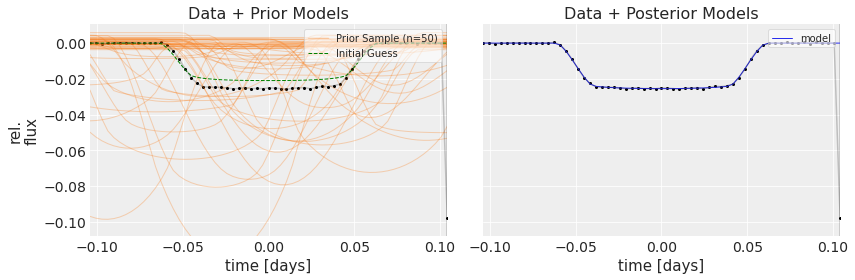

Plotting took --- 0.6634671688079834 seconds ---
Wavelength:  3.003013706207276
Initialising (static) model took --- 0.23674893379211426 seconds ---
Initialising r/u/mean took --- 0.13892793655395508 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -2348.964659813773 -> 409.892250860954


Optimising model took --- 3.3152670860290527 seconds ---
Number of Wavelengths fit : 1


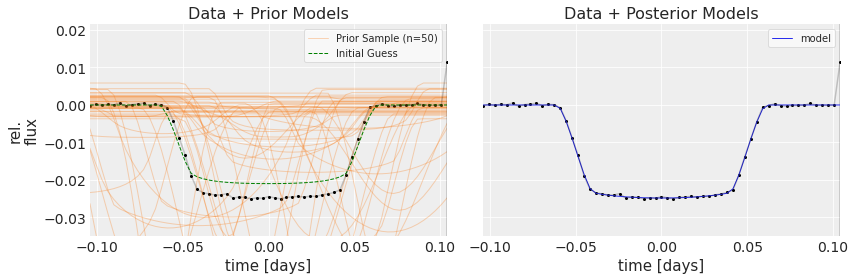

Plotting took --- 0.6623659133911133 seconds ---
Wavelength:  3.203013706207276
Initialising (static) model took --- 0.23101282119750977 seconds ---
Initialising r/u/mean took --- 0.13653874397277832 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1404.0364411898552 -> 388.51782128996723


Optimising model took --- 2.8506157398223877 seconds ---
Number of Wavelengths fit : 1


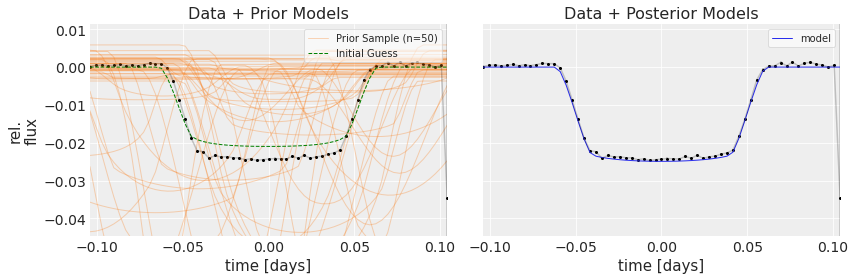

Plotting took --- 1.2066340446472168 seconds ---
Wavelength:  3.4030137062072763
Initialising (static) model took --- 0.23022198677062988 seconds ---
Initialising r/u/mean took --- 0.13593101501464844 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1982.1455576370079 -> 391.9654272216186


Optimising model took --- 2.875962972640991 seconds ---
Number of Wavelengths fit : 1


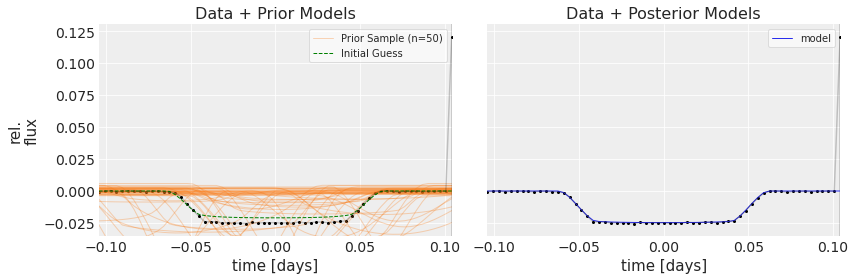

Plotting took --- 1.120352029800415 seconds ---
Wavelength:  3.6030137062072765
Initialising (static) model took --- 0.2301950454711914 seconds ---
Initialising r/u/mean took --- 0.1368720531463623 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1157.9032498644056 -> 386.00537614596226


Optimising model took --- 2.8387928009033203 seconds ---
Number of Wavelengths fit : 1


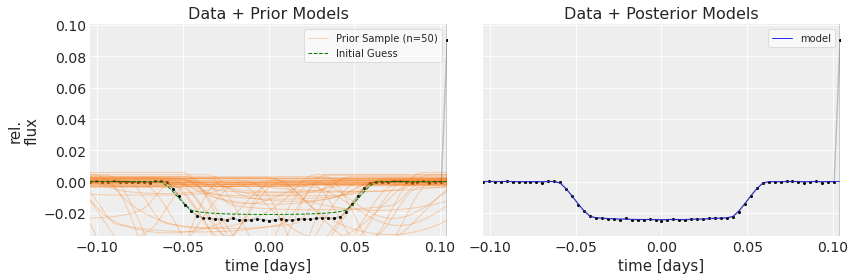

Plotting took --- 0.6696109771728516 seconds ---
Wavelength:  3.8030137062072766
Initialising (static) model took --- 0.22791790962219238 seconds ---
Initialising r/u/mean took --- 0.13556385040283203 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -830.0210231294128 -> 386.3460387256043


Optimising model took --- 2.8761463165283203 seconds ---
Number of Wavelengths fit : 1


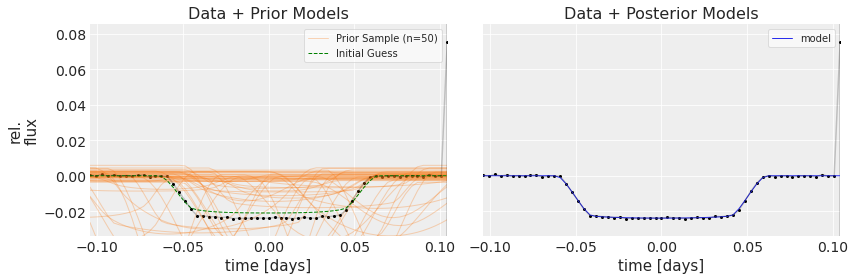

Plotting took --- 0.6645431518554688 seconds ---
Wavelength:  4.003013706207277
Initialising (static) model took --- 0.23023700714111328 seconds ---
Initialising r/u/mean took --- 0.1357710361480713 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -722.9287992291568 -> 399.87234901266106


Optimising model took --- 3.4075069427490234 seconds ---
Number of Wavelengths fit : 1


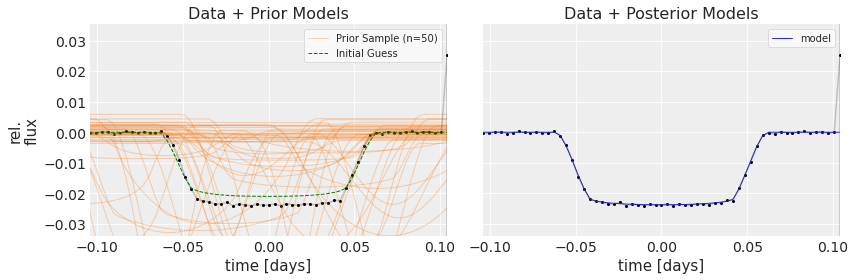

Plotting took --- 0.6643087863922119 seconds ---
Wavelength:  4.203013706207277
Initialising (static) model took --- 0.23761892318725586 seconds ---
Initialising r/u/mean took --- 0.1350080966949463 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -329.2697389320548 -> 365.0552493274052


Optimising model took --- 3.6066970825195312 seconds ---
Number of Wavelengths fit : 1


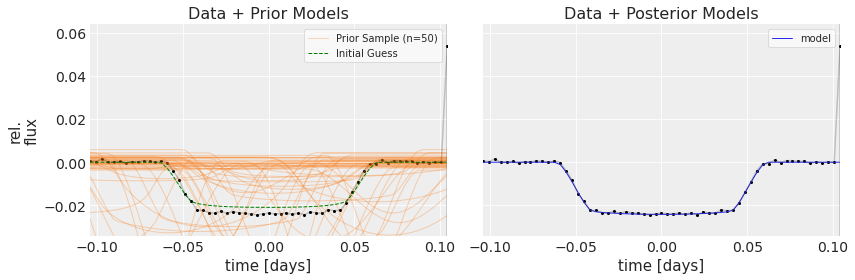

Plotting took --- 0.6509566307067871 seconds ---


In [16]:
cm.reinitialise()
cm.run(b_withtransit,optimisation='separate_wavelengths')

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 17 seconds.


Sampling the posterior took --- 27.51536226272583 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 26.737187147140503 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 25.613394260406494 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 16 seconds.


Sampling the posterior took --- 25.864169120788574 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 26.756528854370117 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 26.046128034591675 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 16 seconds.


Sampling the posterior took --- 25.471377849578857 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 16 seconds.


Sampling the posterior took --- 28.024484157562256 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 16 seconds.


Sampling the posterior took --- 26.38487720489502 seconds ---


Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 600 tune and 1_200 draw iterations (2_400 + 4_800 draws total) took 15 seconds.


Sampling the posterior took --- 25.91087293624878 seconds ---
Number of Wavelengths fit : 10
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'
'dict' object has no attribute 'nchains'


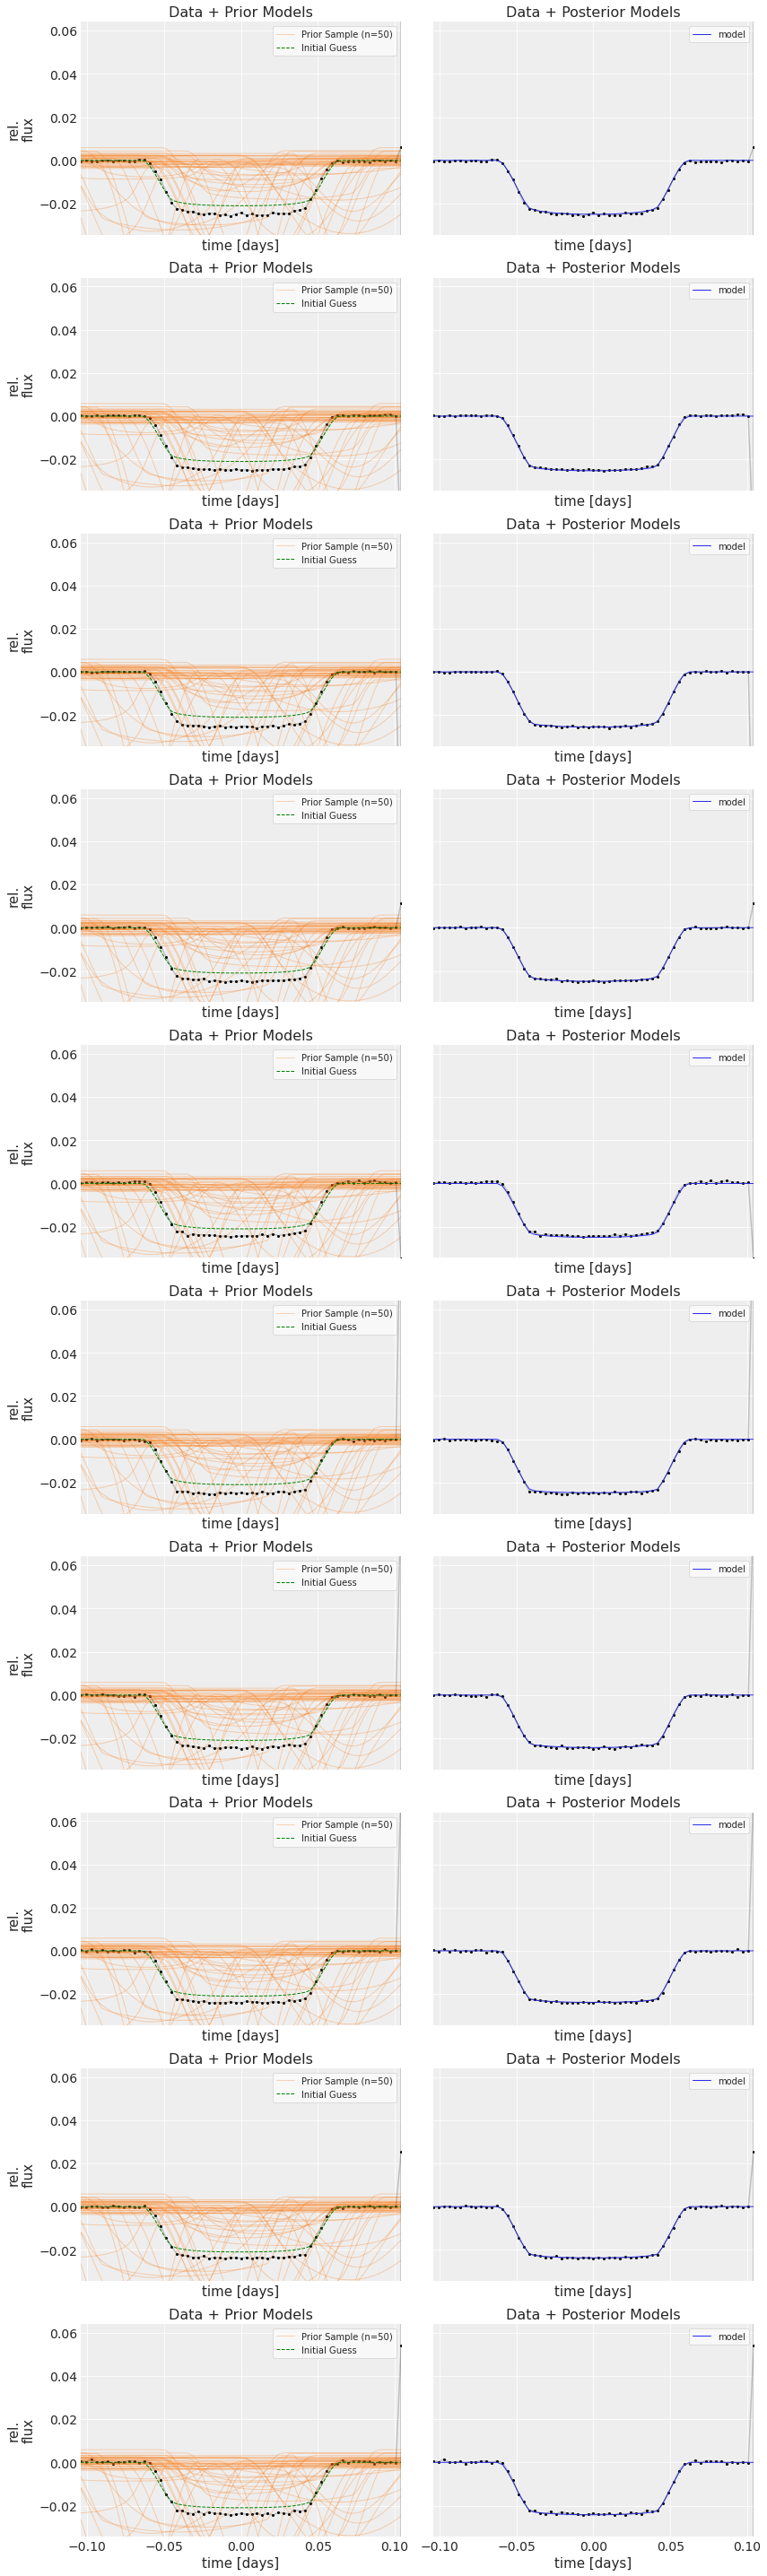

In [17]:
cm.sample_posterior(tune_steps=600,draws=1200,target_accept=0.9)

In [23]:
cm.cornerplot()
summary = cm.summarise()
summary

[period ~ Deterministic r ~ Uniform t0 ~ Normal b ~ ImpactParameter
 u ~ QuadLimbDark mean ~ Normal]


MissingInputError: Input 0 of the graph (indices start from 0), used to compute sigmoid(logP_interval__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [42]:
trace = cm.trace
model = cm.model

for mod, tra in zip(model, trace):
    print(mod,tra)
    print("Not implemented yet")
    all_vars = [cm.P, cm.r, cm.t0, cm.b, cm.u_ld, cm.mean]
    print(mod.test_point, all_vars)
    pmx.eval_in_model(all_vars, mod.test_point, model=mod)
    cornerplot(mod, tra, cm.P, cm.r, cm.t0, cm.b, cm.u_ld, cm.mean)

 logP_interval__ ~ TransformedDistribution
              t0 ~ Normal
      b_impact__ ~ TransformedDistribution
    r_interval__ ~ TransformedDistribution
            mean ~ Normal
u_quadlimbdark__ ~ TransformedDistribution
            logP ~ Uniform
          period ~ Deterministic
               b ~ ImpactParameter
               a ~ Deterministic
               i ~ Deterministic
           a/r_s ~ Deterministic
               r ~ Uniform
               u ~ QuadLimbDark
             r_p ~ Deterministic
    light_curves ~ Deterministic
             r_s ~ Normal
             m_s ~ Normal
             obs ~ Normal <MultiTrace: 4 chains, 1200 iterations, 16 variables>
Not implemented yet
{'logP_interval__': array(2.21934013e-05), 't0': array(0.), 'b_impact__': array(-0.46430561), 'r_interval__': array(-0.20763936), 'mean': array(0.), 'u_quadlimbdark__': array([-1.65822808, -2.7080502 ])} [period ~ Deterministic, r ~ Uniform, t0 ~ Normal, b ~ ImpactParameter, u ~ QuadLimbDark, mean ~ Norm

MissingInputError: Input 0 of the graph (indices start from 0), used to compute sigmoid(logP_interval__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [39]:
cm.logP

logP ~ Uniform

### compare to model!

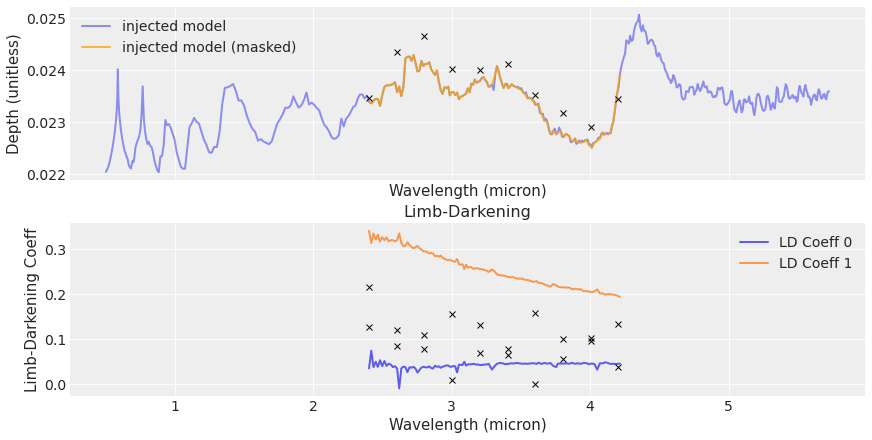

In [22]:
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(12, 6))
ax1 = model_ld.plot(ax=ax1)
ax1 = model_ld.plotmask(ax=ax1)
ax2 = model_ld.plotLDcoeffs(ax=ax2)
for n in range(len(cm.wavelength)):
    u_ld = cm.result[n]['u']
    ax2.plot(cm.wavelength[n],u_ld[0],'kx')
    ax2.plot(cm.wavelength[n],u_ld[1],'kx')
    ror = cm.result[n]['r']
    ax1.plot(cm.wavelength[n],ror**2,'kx')
ax1.legend(frameon=False)
ax2.legend(frameon=False)
plt.show()
plt.close()

### Simultaneous wavelength fitting:

Initialising (static) model took --- 0.24448108673095703 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [wavelength_3_mean, wavelength_3_ror, wavelength_3_u, wavelength_2_mean, wavelength_2_ror, wavelength_2_u, wavelength_1_mean, wavelength_1_ror, wavelength_1_u, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -6823.489132640607 -> 1205.8102099198434
optimizing logp for variables: [wavelength_3_mean, wavelength_3_u, wavelength_3_ror]


message: Optimization terminated successfully.
logp: 1205.8102099198434 -> 1205.8102099198447


list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


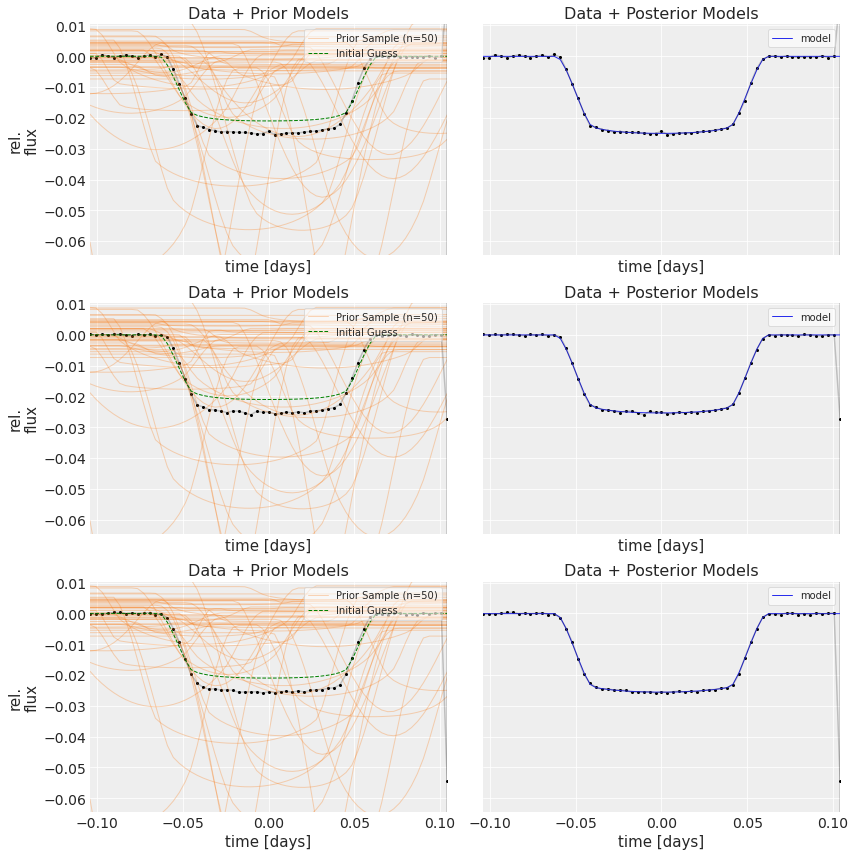

Optimising model took --- 17.417485237121582 seconds ---


In [16]:
cm.reinitialise()
nwave = 4
cm.run(b_withtransit,optimisation='simultaneous',nwave=nwave)

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [wavelength_3_mean, wavelength_3_ror, wavelength_3_u, wavelength_2_mean, wavelength_2_ror, wavelength_2_u, wavelength_1_mean, wavelength_1_ror, wavelength_1_u, b, t0, logP]


Sampling 4 chains for 6_000 tune and 12_000 draw iterations (24_000 + 48_000 draws total) took 154 seconds.
The acceptance probability does not match the target. It is 0.8815118995888964, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847543302201897, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926551667746101, but should be close to 0.8. Try to increase the number of tuning steps.


Sampling the posterior took --- 268.6477589607239 seconds ---


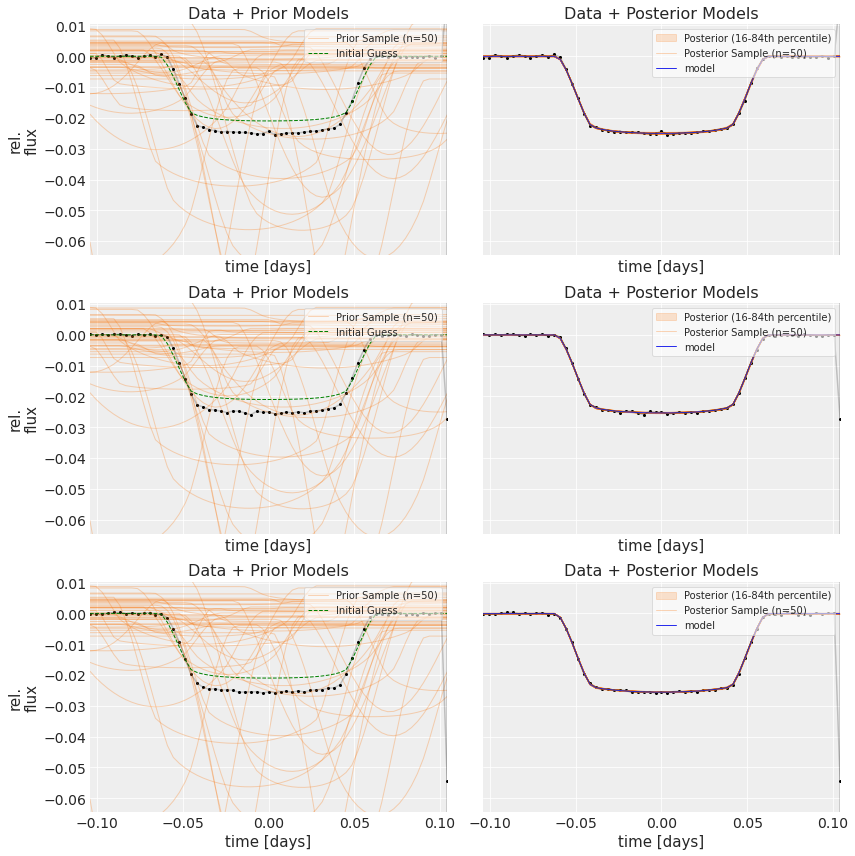

In [17]:
cm.sample_posterior(tune_steps=6000,draws=12000,target_accept=0.9)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


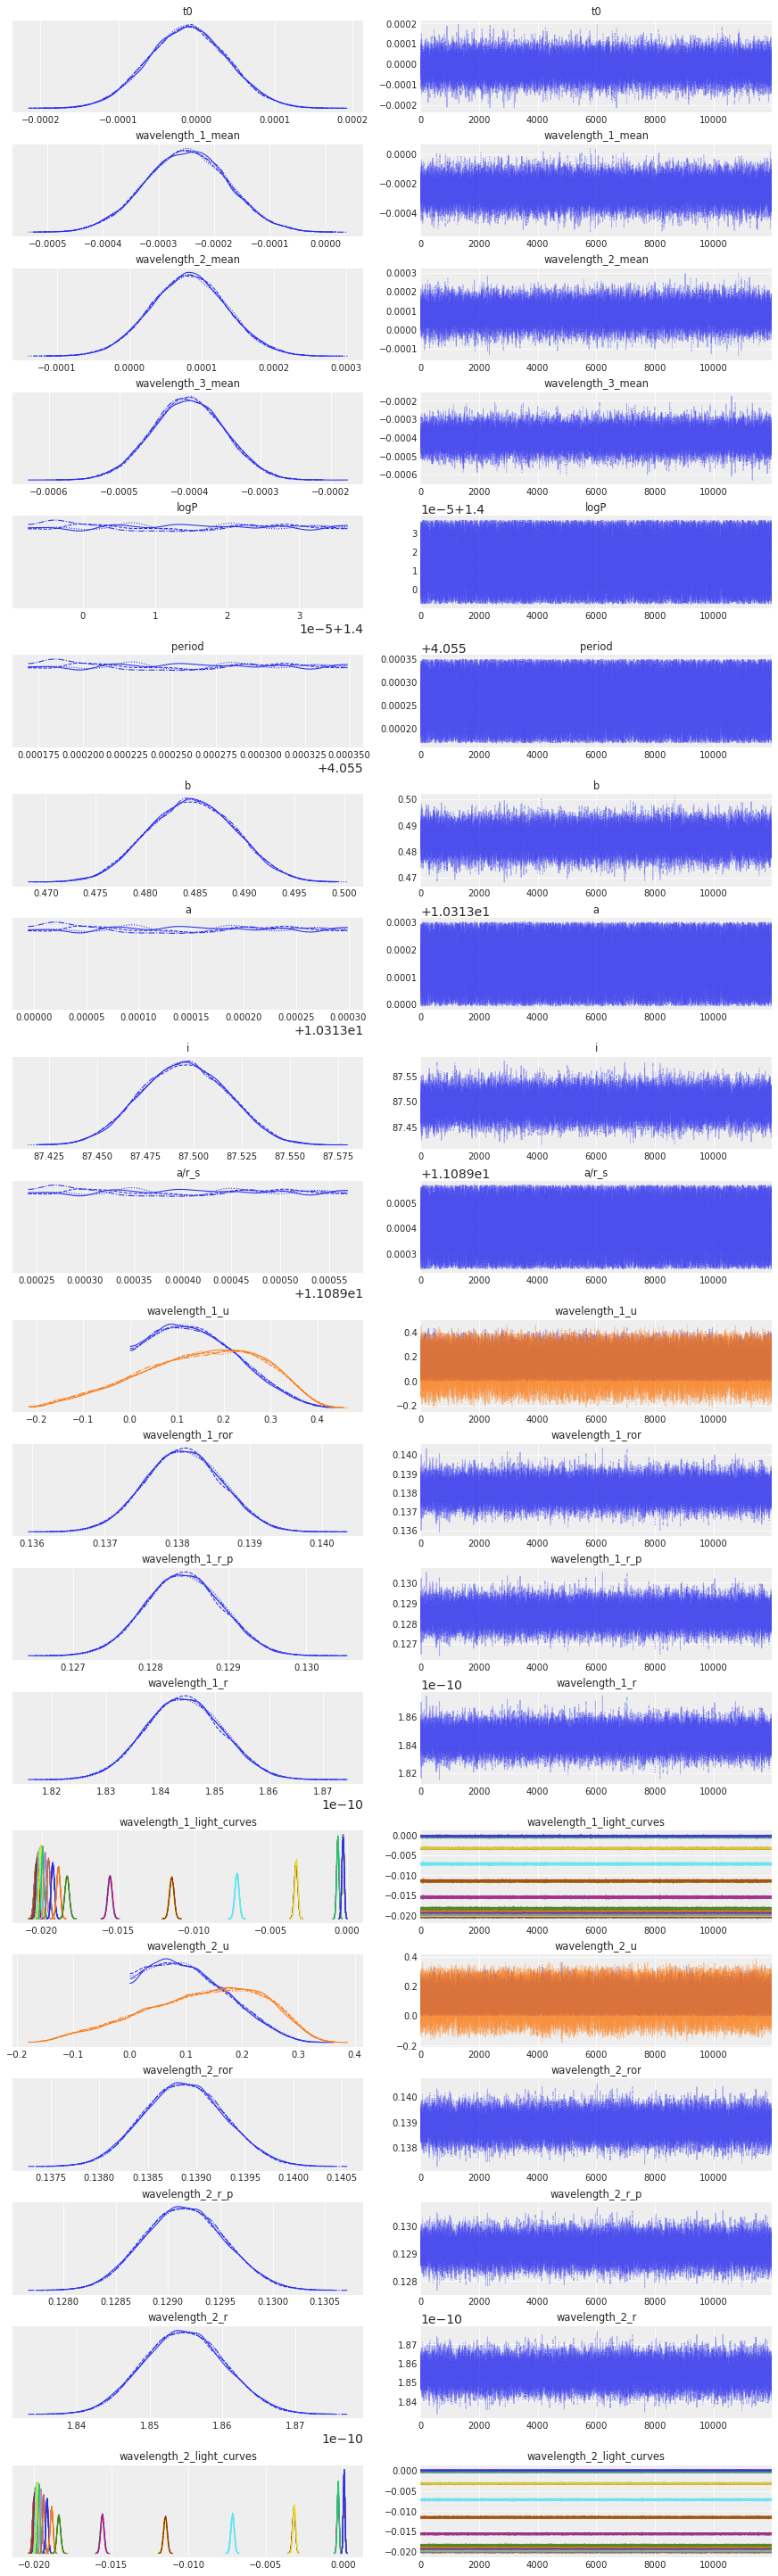

In [30]:
cm.plot_trace()

object of type 'builtin_function_or_method' has no len()
object of type 'builtin_function_or_method' has no len()
object of type 'builtin_function_or_method' has no len()


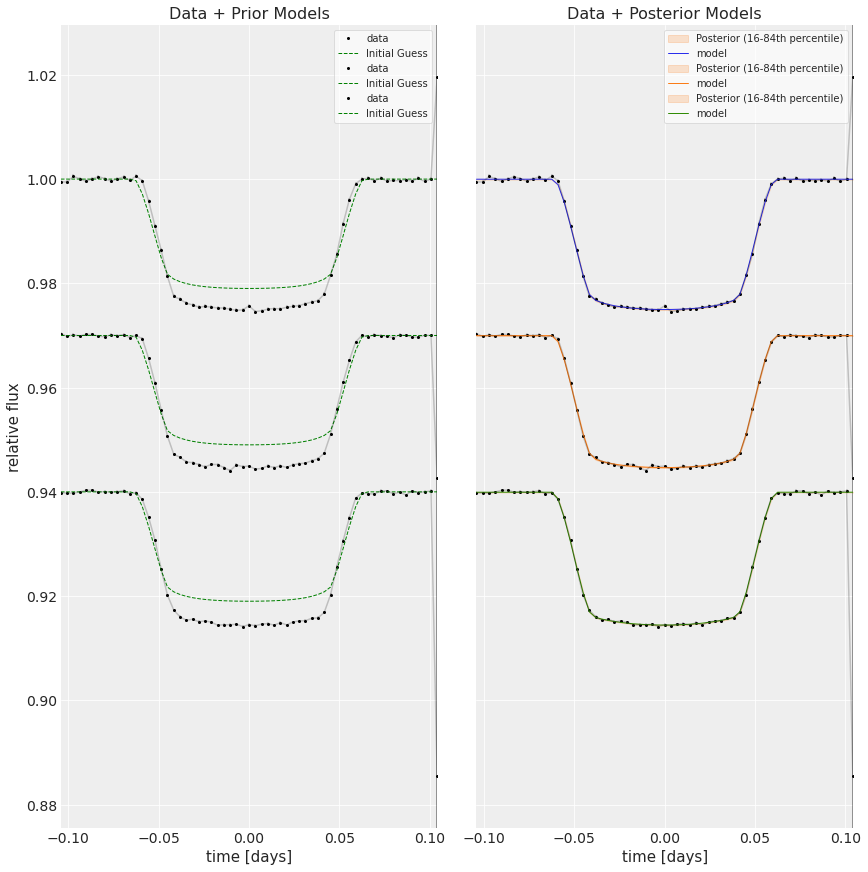

In [18]:
cm.plot_simultaneous_fit() # a better plot for seeing all fits at once?

### Compare to model!

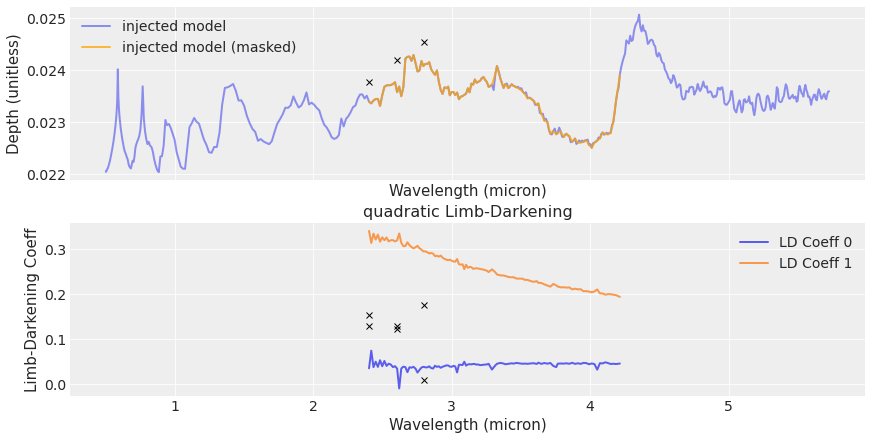

In [19]:
# nwave = 3
# model_ld_test = model_ld
# model_ld_test.table['depth'] = np.sqrt(model_ld.table['depth'])
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(12, 6))
ax1 = model_ld.plot(ax=ax1)
ax1 = model_ld.plotmask(ax=ax1)
ax2 = model_ld.plotLDcoeffs(ax=ax2)
for n in range(nwave):
    u_ld = cm.result[f'wavelength_{n+1}_u']
    ax2.plot(cm.wavelength[n],u_ld[0],'kx')
    ax2.plot(cm.wavelength[n],u_ld[1],'kx')
    ror = cm.result[f'wavelength_{n+1}_ror']
    ax1.plot(cm.wavelength[n],ror**2,'kx')
ax1.legend(frameon=False)
ax2.legend(frameon=False)
plt.show()
plt.close()

## Trying out Corner + Summary with the multi-wavelength fit (v experimental!)

In [14]:
cm.model[0]

Got error No model on context stack. trying to find log_likelihood in translation.


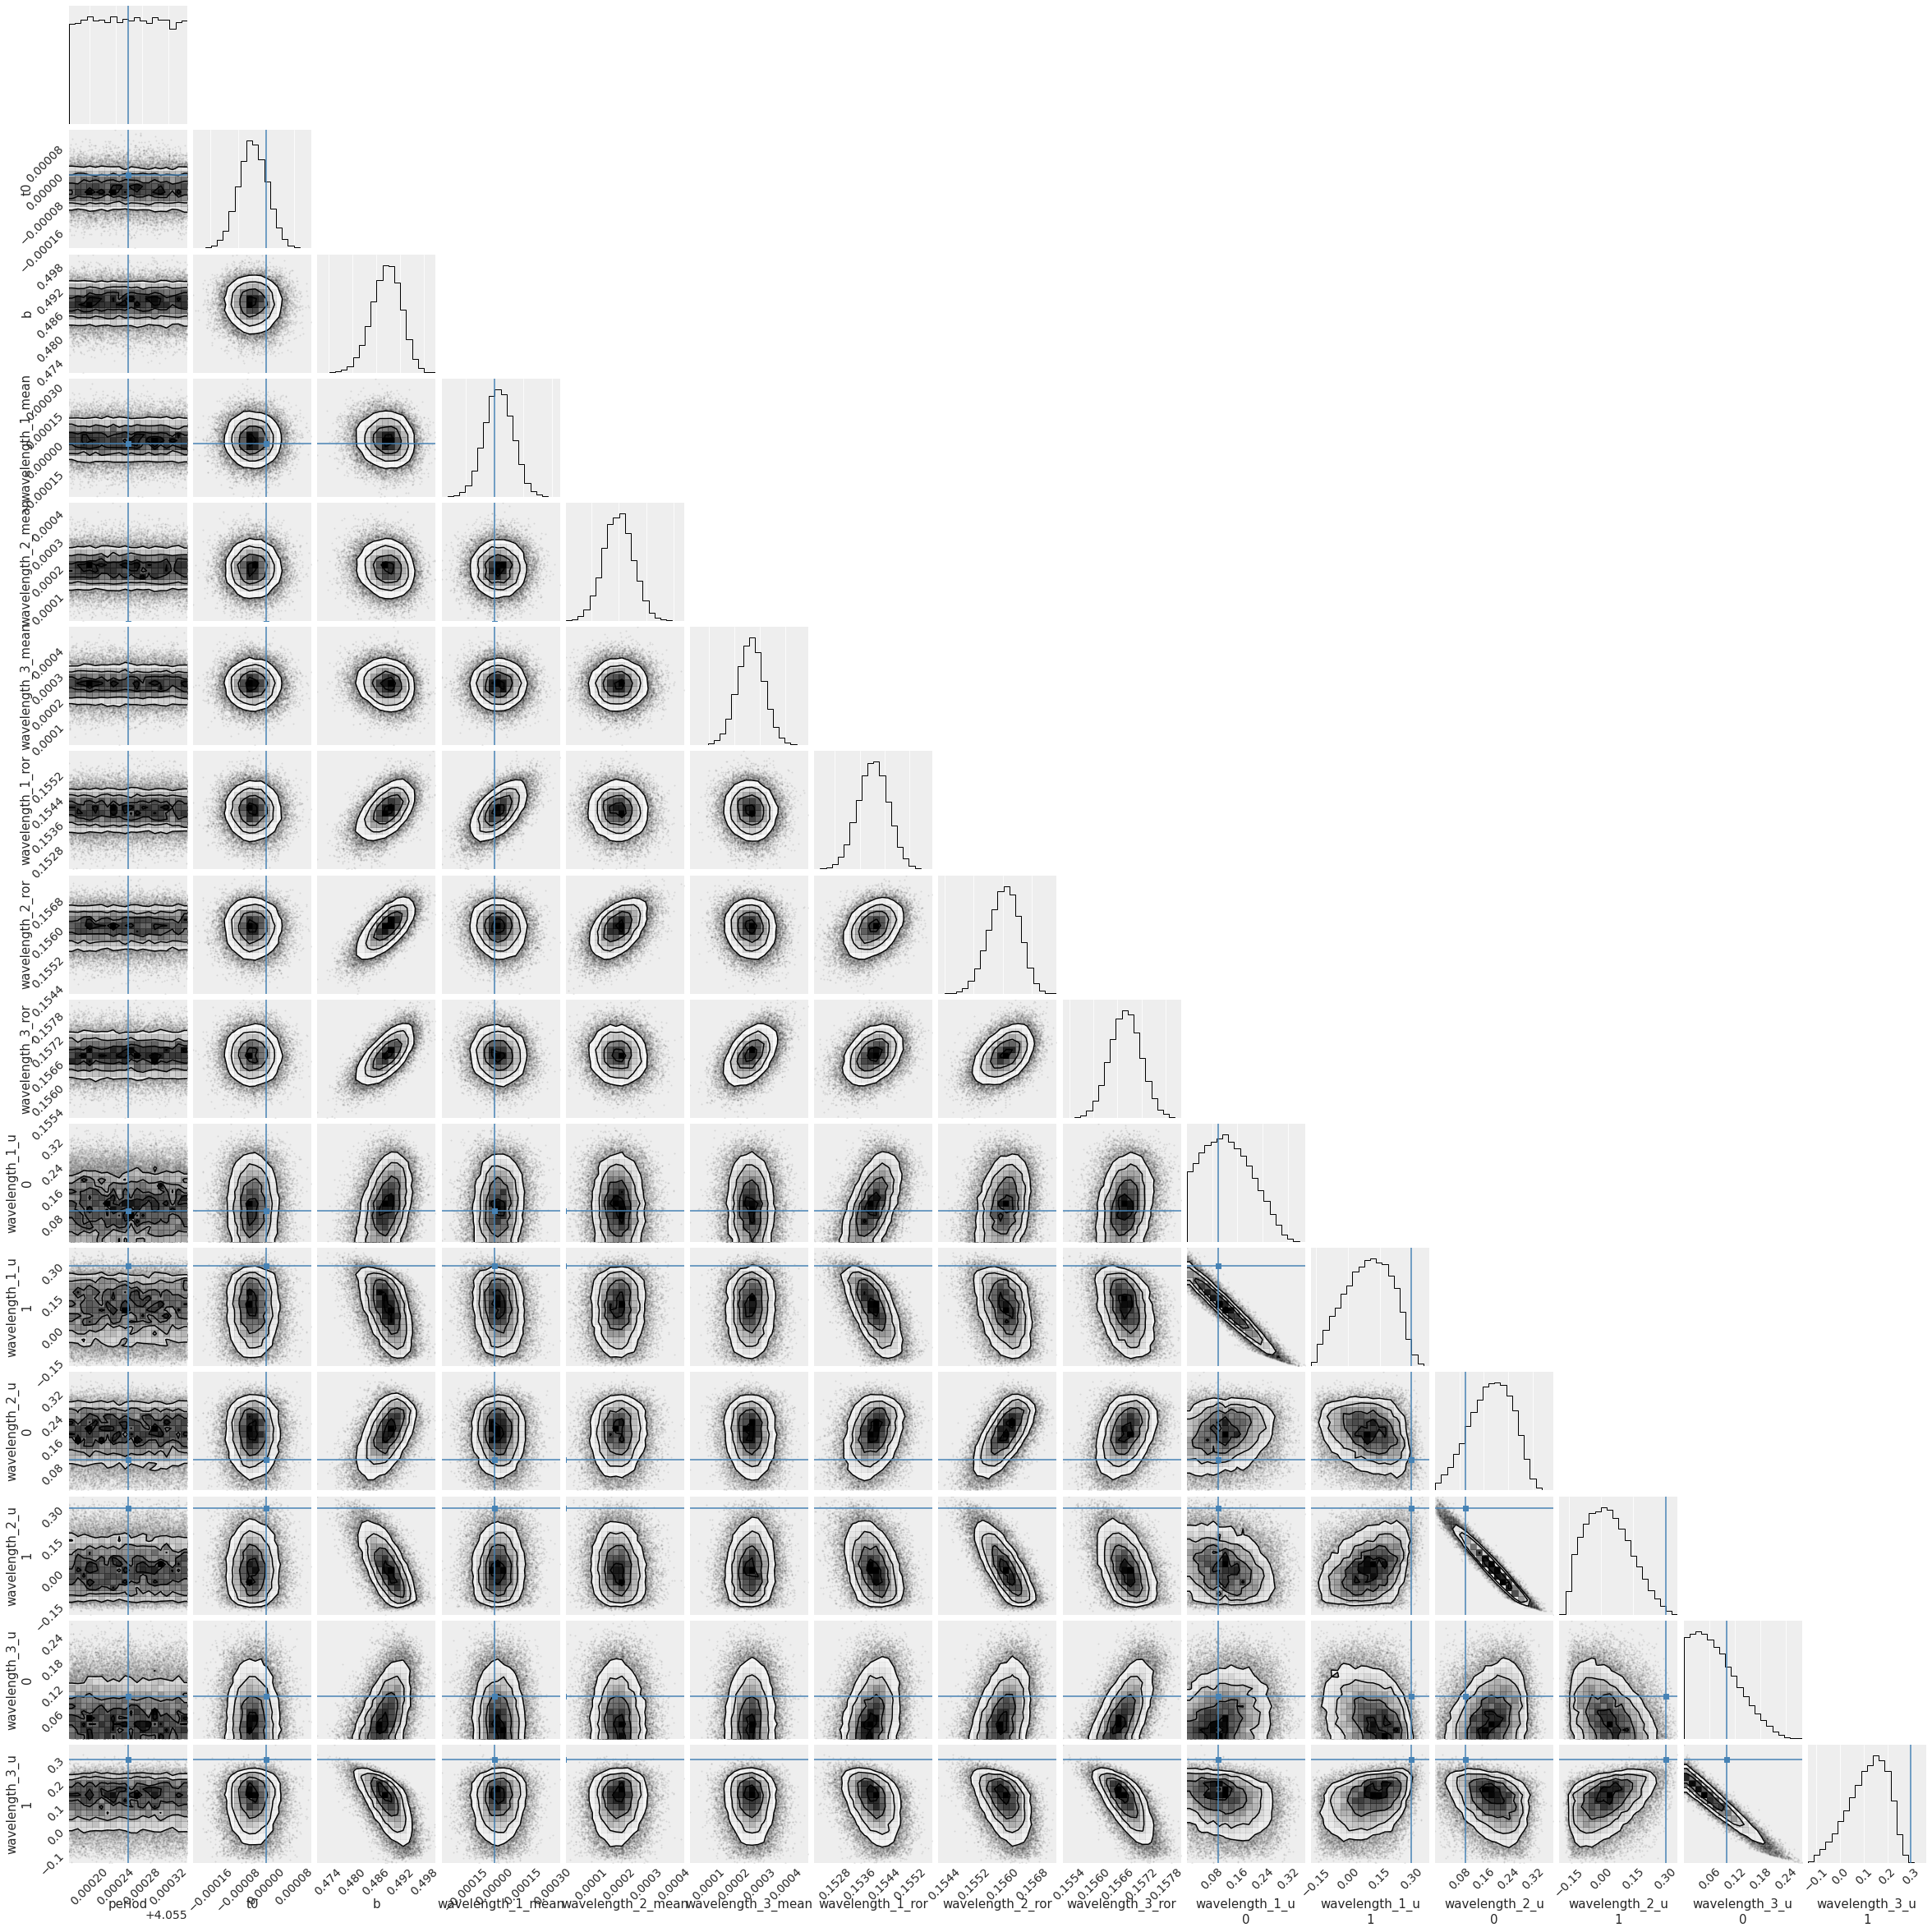

In [22]:
# cm.cornerplot()
# summary = cm.summarise()
# summary
varnames = ['period', 't0', 'b',
            'wavelength_1_mean',  'wavelength_2_mean', 'wavelength_3_mean', 
            'wavelength_1_ror', 'wavelength_2_ror','wavelength_3_ror', 
            'wavelength_1_u', 'wavelength_2_u', 'wavelength_3_u']
all_vars = [cm.model.period,cm.model.t0,cm.model.b,
            cm.model.wavelength_1_mean, cm.model.wavelength_2_mean, cm.model.wavelength_3_mean,
            cm.model.wavelength_1_ror, cm.model.wavelength_2_ror, cm.model.wavelength_3_ror,
            cm.model.wavelength_1_u, cm.model.wavelength_2_u,cm.model.wavelength_3_u
           ]

truth = dict(
    zip(
        varnames,
        pmx.eval_in_model(all_vars, cm.model.test_point, model=cm.model),
        )
    )
_ = corner.corner(
        cm.trace,
        var_names=varnames,
        truths=truth,
    )

In [23]:
with cm.model:
    summary = az.summary(
        cm.trace, var_names=varnames, round_to=7, fmt='wide'
    )
summary

mean        sd        hdi_3%   hdi_97%     mcse_mean  \
period             4.055259  0.000052  4.055177e+00  4.055346  3.000000e-07   
t0                -0.000039  0.000041 -1.157000e-04  0.000039  2.000000e-07   
b                  0.488525  0.003643  4.814477e-01  0.495033  2.530000e-05   
wavelength_1_mean  0.000021  0.000074 -1.149000e-04  0.000161  4.000000e-07   
wavelength_2_mean  0.000198  0.000054  9.820000e-05  0.000300  3.000000e-07   
wavelength_3_mean  0.000264  0.000052  1.641000e-04  0.000361  3.000000e-07   
wavelength_1_ror   0.154023  0.000490  1.531002e-01  0.154938  3.000000e-06   
wavelength_2_ror   0.156030  0.000418  1.552223e-01  0.156778  2.700000e-06   
wavelength_3_ror   0.156793  0.000383  1.560706e-01  0.157504  2.500000e-06   
wavelength_1_u[0]  0.129299  0.075011  2.600000e-06  0.254191  4.638000e-04   
wavelength_1_u[1]  0.093773  0.108479 -1.138905e-01  0.272433  7.053000e-04   
wavelength_2_u[0]  0.182920  0.068924  5.527050e-02  0.305351  4.462000e-04   
wavelength_2_u[1]  0.033083  0.103686 -1.481242e-01  0.215288  7.074000e-04   
wavelength_3_u[0]  0.076992  0.052615  5.000000e-07  0.170850  3.423000e-04   
wavelength_3_u[1]  0.116864  0.082732 -4.180410e-02  0.256352  5.778000e-04   

                        mcse_sd      ess_bulk      ess_tail     r_hat  
period             2.000000e-07  35267.704126  20959.806031  1.000058  
t0                 2.000000e-07  35201.116462  25527.500790  1.000207  
b                  1.790000e-05  21025.478236  20232.328137  1.000038  
wavelength_1_mean  4.000000e-07  35771.744103  25697.962127  1.000122  
wavelength_2_mean  2.000000e-07  32576.444819  24108.535852  1.000152  
wavelength_3_mean  2.000000e-07  35949.727406  25073.688073  0.999993  
wavelength_1_ror   2.100000e-06  27324.044100  23167.927445  1.000083  
wavelength_2_ror   1.900000e-06  23937.267615  22357.962449  1.000269  
wavelength_3_ror   1.800000e-06  23133.664182  23626.341324  0.999983  
wavelength_1_u[0]  3.287000e-04  21689.096083  12689.726396  1.000357  
wavelength_1_u[1]  5.336000e-04  23023.648005  18068.859885  1.000269  
wavelength_2_u[0]  3.349000e-04  21781.139294  13038.089054  1.000115  
wavelength_2_u[1]  5.629000e-04  18696.694654  10828.797118  1.000003  
wavelength_3_u[0]  2.420000e-04  19339.052223  12228.059455  1.000242  
wavelength_3_u[1]  4.086000e-04  20553.315894  20442.753987  1.000210